In [19]:
import sys
sys.path.append("..")

In [20]:
import os
IN_KAGGLE = 'KAGGLE_URL_BASE' in os.environ
IN_KAGGLE

False

In [21]:
if IN_KAGGLE:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value = user_secrets.get_secret("gittoken2")

    !git clone https://{secret_value}@github.com/moienr/TemporalGAN.git

In [22]:
if IN_KAGGLE:
    import time
    import os
    sleep_time = 5
    while not os.path.exists("/kaggle/working/TemporalGAN"):
        print("didn't find the path, wating {sleep_time} more seconds...")
        time.sleep(sleep_time)
    print("path found...")
    import sys
    sys.path.append("/kaggle/working/TemporalGAN")

In [23]:
import torch
torch.__version__

'1.13.1'

In [24]:
import numpy as np
from torch.utils.data import Dataset
from glob import glob
from skimage import io
import os
from torchvision import datasets, transforms
import matplotlib
import os
import gc
import random
from datetime import date, datetime
import json
import pprint
os.cpu_count()

20

In [25]:
# create a folder called 'results' in the current directory if it doesn't exist
if not os.path.exists('results'):
    os.mkdir('results')

In [26]:
# Format the date and time
now = datetime.now()
start_string = now.strftime("%Y-%m-%d %H:%M:%S")
print("Current Date and Time:", start_string)

Current Date and Time: 2023-05-09 14:18:01


In [27]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [28]:
from dataset.data_loaders import *
from dataset.utils.plot_utils import plot_s1s2_tensors, save_s1s2_tensors_plot
#from config import *
from train_utils import *

In [29]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

In [30]:
s1_t1_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s1_imgs\\test"
s2_t1_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s2_imgs\\test"
s1_t2_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s1_imgs\\test"
s2_t2_dir_train="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s2_imgs\\test"
s1_t1_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s1_imgs\\test"
s2_t1_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2021\\s2_imgs\\test"
s1_t2_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s1_imgs\\test"
s2_t2_dir_test="E:\\s1s2\\s1s2_patched_light\\s1s2_patched_extra_light\\2019\\s2_imgs\\test"

In [31]:
TWO_WAY_DATASET = True if IN_KAGGLE else False
INPUT_CHANGE_MAP = True if IN_KAGGLE else False
S2_INCHANNELS = 12 if INPUT_CHANGE_MAP else 6
S1_INCHANNELS = 7 if INPUT_CHANGE_MAP else 1

LEARNING_RATE = 2e-4
BATCH_SIZE = 4 if IN_KAGGLE else 1
NUM_WORKERS = 2 if IN_KAGGLE else 8
IMAGE_SIZE = 256
WEIGHTED_LOSS = True
L1_LAMBDA = 100
CHANGED_L1_WEIGHT = 5
NUM_EPOCHS = 10 if IN_KAGGLE else 1

LOAD_MODEL = False
SAVE_MODEL = True if IN_KAGGLE else False
SAVE_MODEL_EVERY_EPOCH = 10
SAVE_EXAMPLE_PLOTS = True
EXAMPLES_TO_PLOT = [1,32,64,128,256,512,1024] if IN_KAGGLE else [1,2]
CHECKPOINT_DISC = "disc.pth.tar"
CHECKPOINT_GEN = "gen.pth.tar"

RANDOM_SEED = 75

In [32]:
transform = transforms.Compose([S2S1Normalize(),myToTensor(dtype=torch.float32)])


train_dataset = Sen12Dataset(s1_t1_dir=s1_t1_dir_train,
                                s2_t1_dir=s2_t1_dir_train,
                                s1_t2_dir=s1_t2_dir_train,
                                s2_t2_dir=s2_t2_dir_train,
                                transform=transform,
                                two_way=TWO_WAY_DATASET)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    )

In [33]:
for image in train_loader:
    print(len(image))

7
7
7
7


In [34]:
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [36]:
transform = transforms.Compose([S2S1Normalize(),myToTensor()])
test_dataset = Sen12Dataset(s1_t1_dir=s1_t1_dir_test,
                            s2_t1_dir=s2_t1_dir_test,
                            s1_t2_dir=s1_t2_dir_test,
                            s2_t2_dir=s2_t2_dir_test,
                            transform=transform,
                            two_way=TWO_WAY_DATASET)


In [69]:
s2t2,s1t2,s2t1,s1t1,cm,rcm,s1cm = test_dataset[3]

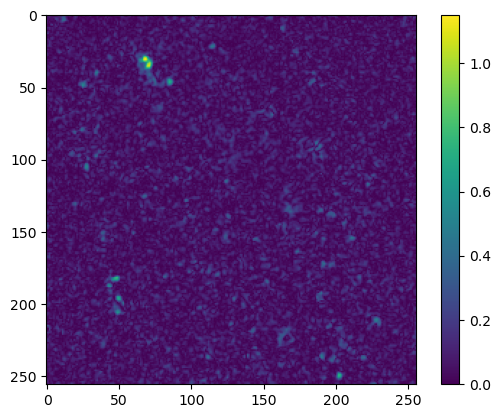

In [70]:
diff = torch.abs(s1t2 - s1t1)

plt.imshow(diff[0,:,:])
plt.colorbar()

In [120]:
from skimage.filters import threshold_otsu


In [121]:
diff_np = diff.numpy()
thresh = threshold_otsu(diff_np)
thresh

0.08765

In [122]:
binary_diff = (diff_np > thresh).astype(int)

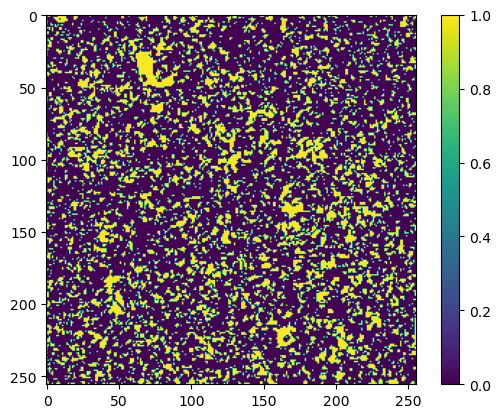

In [123]:
plt.imshow(binary_diff[0,:,:])
plt.colorbar()

In [162]:
def triclass(img, stopval=0.01, repeatnum=10):
    # Convert the input image to a numpy array
    img = np.array(img)

    # Get the minimum and maximum pixel values
    min_val = np.min(img)
    max_val = np.max(img)

    # Normalize the image so that its pixel values range from 0 to 1
    img_norm = (img - min_val) / (max_val - min_val)

    # Initialize the threshold to be 0.2
    threshold = 0.1

    # Perform iterative thresholding
    for i in range(1, repeatnum+1):
        # Divide the image into three classes based on the current threshold
        class1 = img_norm[img_norm <= threshold]
        class2 = img_norm[(img_norm > threshold) & (img_norm < 1)]
        class3 = img_norm[img_norm >= 1]

        # Compute the mean pixel value of each class
        mean1 = np.mean(class1)
        mean2 = np.mean(class2)
        mean3 = np.mean(class3)

        # Compute the new threshold as the average of the means of the three classes
        new_threshold = (mean1 + mean2 + mean3) / 3

        # Check if the difference between the new and old thresholds is smaller than the preset threshold
        if abs(new_threshold - threshold) < stopval:
            break

        # Update the threshold
        threshold = new_threshold

    # Convert the threshold back to the original pixel value range
    threshold = threshold * (max_val - min_val) + min_val

    # Apply the threshold to the input image
    img_thres = img >= threshold

    # Return the thresholded image
    return threshold


In [163]:
thresh = triclass(diff_np)
thresh

0.6852912902832031

In [164]:
binary_diff = (diff_np > thresh).astype(int)

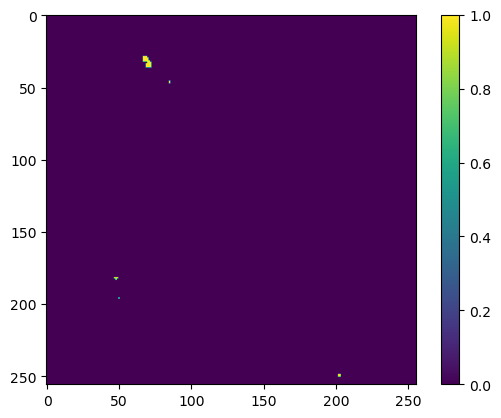

In [165]:
plt.imshow(binary_diff[0,:,:])
plt.colorbar()